### Importing Relevant Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

### Loading and Transforming the Data

In [3]:
raw_csv_data = pd.read_csv("dataset/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')



### Removing Surplus Data

In [4]:
df_comp['market_value']=df_comp.spx

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### White Noise

In [6]:
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))

In [7]:
df['wn'] = wn

<ipython-input-7-f05b4814bfab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wn'] = wn


In [8]:
# since each data point is generated independently, so no exact same mean
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1094.952391
std,292.559287,292.380488
min,438.920000,2.377068
25%,914.620000,900.048961
50%,1144.650000,1094.399787
75%,1316.280729,1286.606971
max,1570.252238,2131.097609


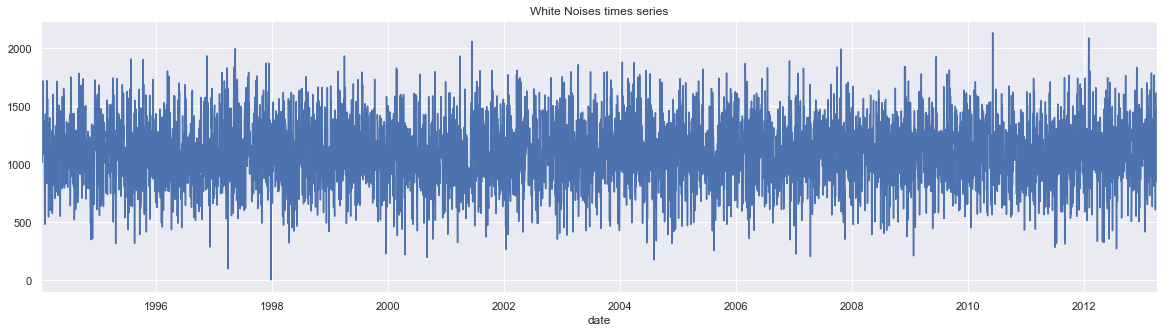

In [9]:
df.wn.plot(figsize=(20,5))
plt.title('White Noises times series')
plt.show()

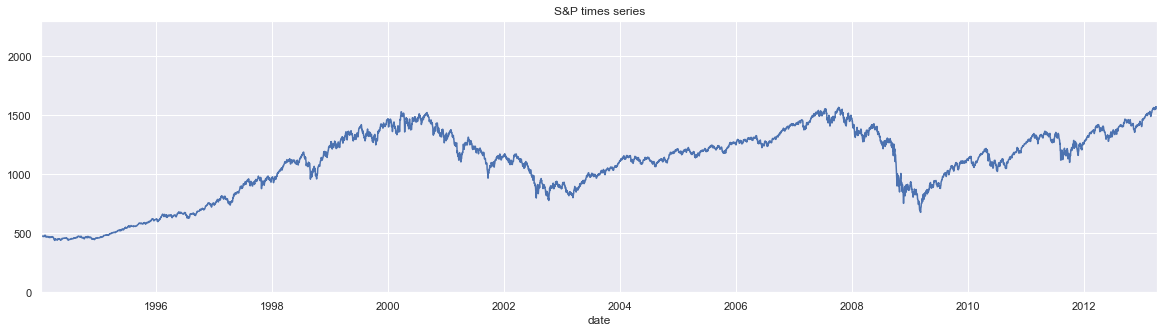

In [11]:
df.market_value.plot(figsize=(20,5))
plt.title('S&P times series')
plt.ylim(0, 2300)
plt.show()

### Random Walk

In [12]:
rw = pd.read_csv('dataset/RandWalk.csv')

In [13]:
rw.date = pd.to_datetime(rw.date, dayfirst=True)

In [14]:
rw.set_index('date', inplace=True)

In [16]:
rw.asfreq('b')

,price
date,
1994-01-07,1122.139662
1994-01-10,1080.347860
1994-01-11,1082.095245
1994-01-12,1083.639265
1994-01-13,1067.146255
...,...
2013-04-01,2263.675474
2013-04-02,2225.000870
2013-04-03,2190.787688


In [17]:
df['rw'] = rw.price

<ipython-input-17-ef067d009833>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rw'] = rw.price


In [20]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,830.442695,1122.139662
1994-01-10,475.27,1246.099003,1080.347860
1994-01-11,474.13,1445.883190,1082.095245
1994-01-12,474.17,1016.741866,1083.639265
1994-01-13,472.47,1367.334548,1067.146255


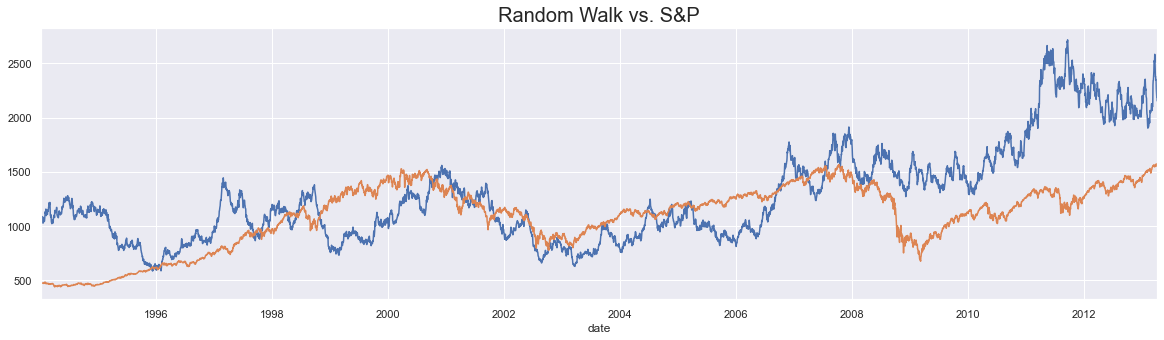

In [22]:
df.rw.plot(figsize=(20,5))
df.market_value.plot()
plt.title('Random Walk vs. S&P', size=20)
plt.show()

### Stationarity

In [23]:
sts.adfuller(df.market_value)
# The first is the value, it's bigger than the all three significance level, so you can't say it has stationarity 
# second is p-value
# third is that there are some auto correlation going back 18 periods, this is for determine t-statistic
# fourth is the number of data used in the process of finding stationarity
# last one is the maximum information criteria provided, the lower the easier that the future can be predicted

(-1.7369847452352432,
 0.41216456967706244,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [24]:
# white noise is stationarity
sts.adfuller(df.wn)

(-70.88280719304531,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 70805.5342351984)

In [25]:
# random walk is non-stationarity
sts.adfuller(df.rw)

(-1.3286073927689714,
 0.6159849181617386,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

### Seasonality

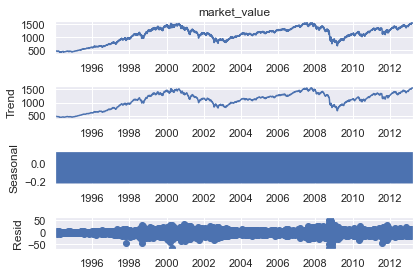

In [26]:
# the trend explain most of the volatility
# the seasonal effect bounce from -0.2 to 0.1 ovewr and over again, means that there's no concrete seasonarity
s_dec_add = seasonal_decompose(df.market_value, model =  'additive')
s_dec_add.plot()
plt.show()

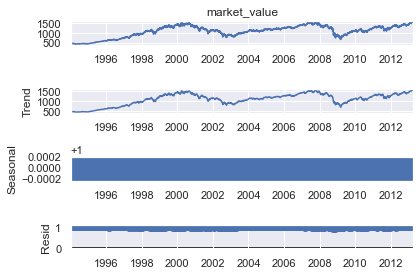

In [27]:
s_dec_add = seasonal_decompose(df.market_value, model =  'multiplicative')
s_dec_add.plot()
plt.show()

### ACF

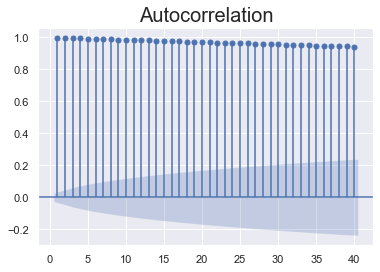

In [29]:
# The correlations are high is selecting no matter how long lagged (1-40) days ago, showing high time dependence
# the blue part is the significance score, it's higher when lagged day increases, reasonable that hard top observe when lagged time is longer
# even a month ago's price can be served as a good indicator of the nowadays value
sgt.plot_acf(df.market_value, lags=40, zero=False)
plt.title('Autocorrelation', size=20)
plt.show()

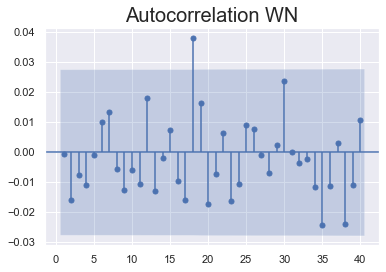

In [32]:
# no autocorrelation for any lag for white noises data
sgt.plot_acf(df.wn, lags=40, zero=False)
plt.title('Autocorrelation WN', size=20)
plt.show()

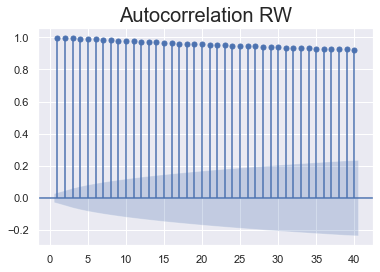

In [33]:
sgt.plot_acf(df.rw, lags=40, zero=False)
plt.title('Autocorrelation RW', size=20)
plt.show()

### PACF

PACF is to prevent from capturing a lot of indirect effect from the previous data, 3 days ago will influence 2 days ago, 2 days ago will influence 1 days ago, so the influence is augmented. PACF canceled out all the additional channels a previous period affects the present one

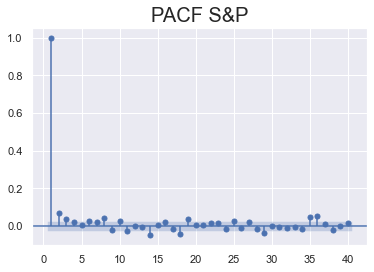

In [34]:
# ols means order of least square
# the first value should be the same tho
# the rest are not significant from 0, can view as random
sgt.plot_pacf(df.market_value, lags=40, zero=False, method=('ols'))
plt.title('PACF S&P', size=20)
plt.show()

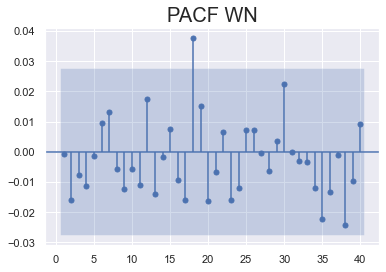

In [35]:
sgt.plot_pacf(df.wn, lags=40, zero=False, method=('ols'))
plt.title('PACF WN', size=20)
plt.show()

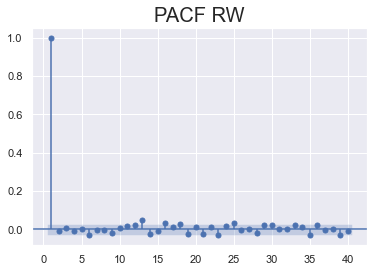

In [36]:
sgt.plot_pacf(df.rw, lags=40, zero=False, method=('ols'))
plt.title('PACF RW', size=20)
plt.show()